# Prueba de RNA usando LSTM

Fuentes:
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- https://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/

Según dicen:

_Neural networks like Long Short-Term Memory (LSTM) recurrent neural networks are able to almost seamlessly model problems with multiple input variables._
_This is a great benefit in time series forecasting, where classical linear methods can be difficult to adapt to multivariate or multiple input forecasting problems._

**IMPORTANTE:** Este ejemplo usa 90 días de datos ficticios sacados de ratio_dwh (dataset simulado)

## Carga y preparación del dataset

In [1]:
# En la Rpi se podría achicar importando solo lo comentado.
# from pandas import DataFrame, Series, concat, read_csv, detime, 
import pandas as pd

# from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import MinMaxScaler
import sklearn

# from keras.models import Sequential
# from keras.layers import Dense, LSTM
import keras

from math import sqrt
from matplotlib import pyplot as plt

import numpy as np

# Import mysql to extract dataset directly from db
import MySQLdb


Using TensorFlow backend.


In [2]:
%matplotlib inline

### Conexión al DWH

In [3]:
# Base de datos histórica
dbname_hist = "ratio_dwh"
dbhost_hist = "localhost"
dbport_hist = 3306
dbuser_hist = "root"
dbpass_hist = "root"
device_events_tbl = "device_events"
device_event_sensors_tbl = "device_event_sensors"
device_modules_tbl = "device_modules"

### Variables de configuración

In [4]:
device_id = 5                   # Device id donde esta el modulo a entrenar
lux_module_id = 51              # Modulo a entrenar

# Variables de tipos de sensores
ACS_SENSOR_TYPE = 1
LIGHT_SENSOR_TYPE = 2
MOVEMENT_SENSOR_TYPE = 3
SOUND_SENSOR_TYPE = 4
TEMP_SENSOR_TYPE = 5

### Funciones

In [5]:
# Funcion para pasar de sensor_id a nombre
def sensorIdToStr(sensor_id):
    return {
        ACS_SENSOR_TYPE: 'LUX_ACS',
        LIGHT_SENSOR_TYPE: 'LIGHT',
        MOVEMENT_SENSOR_TYPE: 'MOVEMENT',
        SOUND_SENSOR_TYPE: 'SOUND',
        TEMP_SENSOR_TYPE: 'TEMPERATURE'
    }.get(sensor_id, sensor_id)

## Extracción de datos del dwh:

In [6]:
# Estrayendo valores de la tabla de eventos
conn = MySQLdb.connect(host=dbhost_hist, port=dbport_hist, user=dbuser_hist, passwd=dbpass_hist, db=dbname_hist)
from_stm = 'FROM ' + device_events_tbl + ' de LEFT JOIN ' + device_event_sensors_tbl + ' des ON de.id=des.device_event_id '
where_stm = 'WHERE device_id = ' + str(device_id) + ' AND module_id = ' + str(lux_module_id) + ' AND ts BETWEEN DATE_SUB(NOW(), INTERVAL 90 DAY) AND NOW()'
%time df_events_qry = pd.read_sql('select ts, state, sensor_type_id, value ' + from_stm + where_stm, con=conn)
conn.close()

CPU times: user 4.51 s, sys: 191 ms, total: 4.7 s
Wall time: 16.1 s


In [7]:
df_events_qry.head(5)

,ts,state,sensor_type_id,value
0,2017-08-18 14:32:00,0,2,611.000000
1,2017-08-18 14:32:00,0,4,31.042223
2,2017-08-18 14:32:00,0,3,0.000000
3,2017-08-18 14:32:00,0,1,0.002365
4,2017-08-18 14:33:00,0,2,599.000000


### Generación de dataset para entrenamiento

In [8]:
# Se elininan los eventos de estado sin sensado
df_events_qry.dropna(inplace=True)

In [9]:
# Se "aplanan" los eventos con una tabla pivot sobre la columna sensor_type_id
df_events = df_events_qry.pivot_table(index=['ts','state'], columns='sensor_type_id', values='value', aggfunc=np.mean)
# Se elimina el multiindex de columnas generado por pivot_table
df_events = df_events.reset_index().rename_axis(None, axis=1)
# Se renombran las columnas
df_events.rename(columns={'ts': 'TIMESTAMP', 'state': 'LUX_ON'},inplace=True)
df_events.columns = [ sensorIdToStr(colname) for colname in df_events.columns ]

In [10]:
df_events.head(5)

,TIMESTAMP,LUX_ON,LUX_ACS,LIGHT,MOVEMENT,SOUND
0,2017-08-18 14:32:00,0,0.002365,611.0,0.0,31.042223
1,2017-08-18 14:33:00,0,0.009989,599.0,0.0,35.124836
2,2017-08-18 14:34:00,0,0.002221,606.0,0.0,35.754298
3,2017-08-18 14:35:00,0,0.008783,588.0,0.0,36.681629
4,2017-08-18 14:36:00,0,0.004167,614.0,0.0,32.231774


In [11]:
df_events.shape

(129600, 6)

## Limpieza del dataset
Debido a que no se necesitan todas las columnas para realizar el entrenamiento de la RNA, se eliminan las que no representen relación con lo que se busca predecir.

- Las medicion LUX_ACS puede ignorarse para este tipo de entrenamiento, ya que es practicamente lineal con LUX_ON.
- Timestamp puede eliminarse, ya que en LSTM se utilizan los valores de registros anteriores para determinar el actual


In [12]:
del df_events['LUX_ACS']
del df_events['TIMESTAMP']

Algunos valores fueron cargados con error, ya sea porque se estaban haciendo pruebas o por falla del hardware. Elimino esas filas.

In [13]:
df_events = df_events[df_events.LIGHT < 1500 ]
df_events = df_events[df_events.SOUND < 120 ]
df_events.max()

LUX_ON        1.000000
LIGHT       703.000000
MOVEMENT      1.000000
SOUND        85.699225
dtype: float64

### Ajuste y transformación de variables
Se aplican ajustes y correcciones a las variables del dataset

In [14]:
df_events['MOVEMENT'] = df_events.MOVEMENT.astype(int)

Cuando se utilizan datos verdaderos (no del dataset simulado), el estado de lux puede ser 0, 1, 2 o 3. Los que tienen estado dos, a los efectos de este análisis, cuentan como 0. Los que tienen valor 3, cuentan como 1. Tengo que corregir esto a mano.

In [15]:
df_events['LUX_ON'] = df_events['LUX_ON'].replace(2, 0)
df_events['LUX_ON'] = df_events['LUX_ON'].replace(3, 1)

### Normalización de los datos
Para normalizar, voy a definir mi propia función, ya que necesito repetir el proceso cuando haga pruebas al final de este ejercicio (lo que sería equivalente a recibir una consulta en el sistema en tiempo real).

La normalización se realiza extrayendo los máximos y mínimos del dataset.

In [16]:
df_events.max()

LUX_ON        1.000000
LIGHT       703.000000
MOVEMENT      1.000000
SOUND        85.699225
dtype: float64

In [17]:
minMax = { 'light': [df_events.min()[1], df_events.max()[1]], 
           'sound': [df_events.min()[3], df_events.max()[3]]
         }

Luego defino funciones para normalizar y desnormalizar, que utilizan los mínimos y máximos guardados anteriormente.

**IMPORTANTE**: Esta función normaliza valores al rango [-1, -1]. Es necesario este rango (en vez del default [0, 1]) porque más adelante se agregan variables de cambio de movimiento que pueden tener como valor -1, 0 o 1, entonces ya no hace falta normalizarlas. Por otro lado, tampoco va a hacer falta "desnormalizar" el resultado.

In [18]:
def normalizar(min, max, value):
    return 2*(value - min)/(max - min) - 1

def desnormalizar(min, max, value):
    return (value+1)*(max - min)/2 + min
    

Normalizo todos los datos que no están todavía entre 0 y 1

In [19]:
df_events['LIGHT'] = normalizar(minMax['light'][0], minMax['light'][1], df_events['LIGHT'])
df_events['SOUND'] = normalizar(minMax['sound'][0], minMax['sound'][1], df_events['SOUND'])

In [20]:
df_events.max()

LUX_ON      1.0
LIGHT       1.0
MOVEMENT    1.0
SOUND       1.0
dtype: float64

Si desnormalizo esos valores, veo que coinciden con los valores originales:

In [21]:
print("Valores de la primera fila:")
print("LIGHT:", desnormalizar(minMax['light'][0], minMax['light'][1], df_events.iloc[0][1]))
print("Sonido:", desnormalizar(minMax['sound'][0], minMax['sound'][1], df_events.iloc[0][3]))

Valores de la primera fila:
LIGHT: 611.0
Sonido: 31.0422227031


## Análisis Exploratorio inicial


Para tener una idea si el sonido acompaña al movimiento, voy a hacer un gráfico que solape ambas variables.

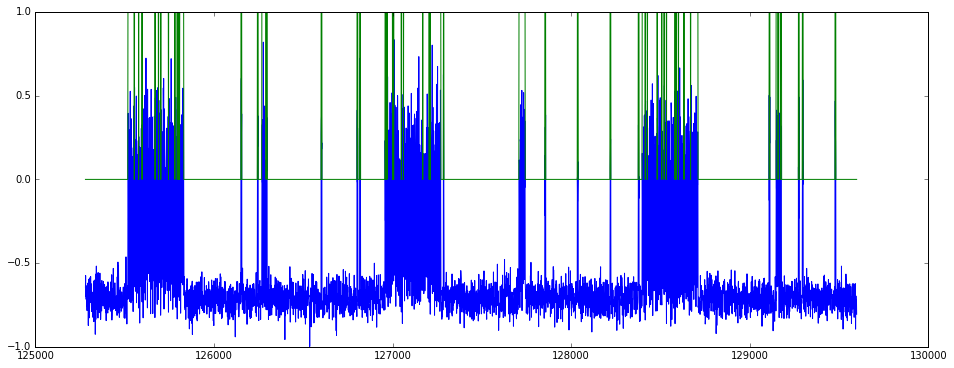

In [22]:
days = 3

plt.figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
#plt.plot(df_events['LIGHT'].tail(days*1440))
plt.plot(df_events['SOUND'].tail(days*1440))
plt.plot(df_events['MOVEMENT'].tail(days*1440))
plt.show()

Se detecta cierta correlación a simple vista, pero no es significativa.

### Función de correlación
Esta función tiene dos entradas:
1. El dataframe panda a analizar
2. El tamáño de gráfico que se quiere imprimir

In [23]:
def plot_corr(df, size=6):
    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks

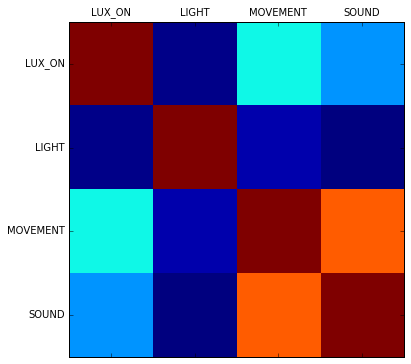

In [24]:
plot_corr(df_events)

In [25]:
df_events.corr().style.bar(subset=['LUX_ON'], color='#d65f5f', axis=0)

## Conversión de serie a aprendizaje supervisado

Convierto los datos de un formato secuencial a uno de aprendizaje supervisado. Para eso tengo que hacer dos cosas:
- Normalizar los valores de las variables al rango de activación de la función tanh() (-1 a 1) (ya está hecho)
- Crear en base a las existentes, que representen los estados previos

### Generación de nuevas variables
Se analizará la relación del estado de la luz (LUX_ON) con variables dependientes del dataset generado. El objetivo es intentar representar relaciones más adecuadas con el entorno tanto a nivel espacial como temporal.
Las mediciones (facts) a construir son:
- LIGHT_1m    medición de luz en el último minuto (sin contar la medición actual)
- MOVEMENT_1m     proporción del sensor PIR activado en el último minuto
- MOVEMENT_5m     proporción del sensor PIR activado en los últimos 5 minutos
- MOVEMENT_15m    proporción del sensor PIR activado en los últimos 15 minutos

In [26]:
df_events['LIGHT_1m'] = df_events.LIGHT.shift(1)
df_events['MOVEMENT_CHANGE'] = df_events.MOVEMENT.diff()
df_events['MOVEMENT_1m'] = df_events.MOVEMENT.shift(1)
df_events['MOVEMENT_5m'] = df_events.MOVEMENT.rolling(5).sum() / 5
df_events['MOVEMENT_15m'] = df_events.MOVEMENT.rolling(15).sum() / 15
df_events['LUX_SWITCH'] = df_events.LUX_ON.diff()
df_events['LIGHT_LAST_STATE'] = df_events.query('LUX_SWITCH != 0').LIGHT_1m
df_events['LIGHT_LAST_STATE'] = df_events['LIGHT_LAST_STATE'].fillna(method='pad')
df_events.dropna(inplace=True)

### Chequeo de valores null

In [27]:
# columnas con null
df_events.isnull().any()

LUX_ON              False
LIGHT               False
MOVEMENT            False
SOUND               False
LIGHT_1m            False
MOVEMENT_CHANGE     False
MOVEMENT_1m         False
MOVEMENT_5m         False
MOVEMENT_15m        False
LUX_SWITCH          False
LIGHT_LAST_STATE    False
dtype: bool

Algunas filas, incluyendo la primera, tendran valores NaN. Voy a eliminar los registros en donde haya algún NaN.

In [28]:
df_events.shape

(129576, 11)

In [29]:
# Se elininan los eventos de estado sin sensado
df_events.dropna(inplace=True)
df_events.isnull().any()

LUX_ON              False
LIGHT               False
MOVEMENT            False
SOUND               False
LIGHT_1m            False
MOVEMENT_CHANGE     False
MOVEMENT_1m         False
MOVEMENT_5m         False
MOVEMENT_15m        False
LUX_SWITCH          False
LIGHT_LAST_STATE    False
dtype: bool

In [30]:
df_events.shape

(129576, 11)

Verifico la correlación por última vez

In [31]:
df_events.corr().style.bar(subset=['LUX_ON'], color='#d65f5f', axis=0)

## Entrenamiento y verificación de RNA

### Variable objetivo: estado de la lámpara (LUX_ON)
La variable a predecir es LUX_ON, la cual está en 1 si la luz está prendida (sea estado override o no del módulo). La distribución del estado en porcentaje es la siguiente:

In [32]:
df_events.LUX_ON.value_counts(normalize=True)

0    0.834506
1    0.165494
Name: LUX_ON, dtype: float64

#### Separando los datos para training y prueba
Para poder hacer etapas de entrenamiento y prueba, voy a separar los datos. 70% para entrenamiento, 30% para prueba. Para esto voy a usar del módulo scikit-learn la función train_test_split.


In [33]:
df_events.head(1)

,LUX_ON,LIGHT,MOVEMENT,SOUND,LIGHT_1m,MOVEMENT_CHANGE,MOVEMENT_1m,MOVEMENT_5m,MOVEMENT_15m,LUX_SWITCH,LIGHT_LAST_STATE
24,1,0.812233,0,-0.711066,0.698435,0.0,0.0,0.0,0.0,1.0,0.698435


Los conjuntos de datos van a llamarse:
* X_train: Datos de entrenamiento. Las 7 columnas con los valores LIGHT, MOVEMENT, SOUND, sus valores en el minuto anterior, y LUX_ON_1m, la variable que quiero predecir, pero en el minuto anterior. Estará compuesto por el 70% de los registros.
* y_train: Resultado de entrenamiento. Columna *LUX_ON* para el 70% de los registros
* X_test: Datos para hacer la validación. Tienen el mismo formato que X_train, pero corresponden al 30% del conjunto de datos
* y_test: Resultados para validar la performance del algoritmo aplicado a X_test

In [34]:
from sklearn.model_selection import train_test_split

luxState_feature_names = ['LIGHT', 'MOVEMENT', 'SOUND', 'LIGHT_1m', 'MOVEMENT_CHANGE', 'MOVEMENT_1m', 'MOVEMENT_5m', 'MOVEMENT_15m', 'LUX_SWITCH', 'LIGHT_LAST_STATE']
luxState_goal_names = ['LUX_ON']

luxState_features = df_events[luxState_feature_names].values     # Columnas del predictor (10 X m)
luxState_goal = df_events[luxState_goal_names].values            # Clase predecida (1=verdadero, 0=falso) column (1 X m)
split_test_size = 0.30                                           # 0.30 es 30%, el tamaño para pruebas

luxState_features_train, luxState_features_test, luxState_goal_train, luxState_goal_test = train_test_split(luxState_features, luxState_goal, test_size=split_test_size)

Verifico que el tamaño relativo de los sets de entrenamiento y prueba sea lo más cercano a 70-30 posible:

In [35]:
print("{0:.2f}% en el set de entrenamiento".format( (float(len(luxState_features_train))/len(df_events.index)) * 100 ) )
print("{0:.2f}% en el set de prueba".format((float(len(luxState_features_test))/len(df_events.index)) * 100))

70.00% en el set de entrenamiento
30.00% en el set de prueba


Verifico que la proporción de casos verdaderos y falsos se mantenga en los conjuntos de entrenamiento y test:

In [36]:
print("Lux Activo en el total           : {0} ({1:0.2f}%)".format(len(df_events.loc[df_events['LUX_ON'] == 1]), (len(df_events.loc[df_events['LUX_ON'] == 1])/float(len(df_events.index))) * 100.0))
print("Lux Inactivo en el total         : {0} ({1:0.2f}%)".format(len(df_events.loc[df_events['LUX_ON'] == 0]), (len(df_events.loc[df_events['LUX_ON'] == 0])/float(len(df_events.index))) * 100.0))
print("")
train_state_on = len(luxState_goal_train[ luxState_goal_train == 1])
train_state_off = len(luxState_goal_train[ luxState_goal_train == 0])
print("Lux Activo en entrenamiento      : {0} ({1:0.2f}%)".format(train_state_on, train_state_on/float(len(luxState_goal_train)) * 100.0))
print("Lux Inctivo en entrenamiento     : {0} ({1:0.2f}%)".format(train_state_off, train_state_off/float(len(luxState_goal_train)) * 100.0))
print("")
test_state_on = len(luxState_goal_test[ luxState_goal_test == 1])
test_state_off = len(luxState_goal_test[ luxState_goal_test == 0])
print("Lux Activo en test               : {0} ({1:0.2f}%)".format(test_state_on, test_state_on/float(len(luxState_goal_test)) * 100.0))
print("Lux Inctivo en test              : {0} ({1:0.2f}%)".format(test_state_off,test_state_off/float(len(luxState_goal_test)) * 100.0))

Lux Activo en el total           : 21444 (16.55%)
Lux Inactivo en el total         : 108132 (83.45%)

Lux Activo en entrenamiento      : 14959 (16.49%)
Lux Inctivo en entrenamiento     : 75744 (83.51%)

Lux Activo en test               : 6485 (16.68%)
Lux Inctivo en test              : 32388 (83.32%)


In [37]:
from sklearn.neural_network import MLPClassifier
clf_model_state = MLPClassifier(activation='tanh')
%time clf_model_state.fit(luxState_features_train, luxState_goal_train.ravel())

CPU times: user 16.2 s, sys: 63.4 ms, total: 16.2 s
Wall time: 16.9 s


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

#### Performance usando los datos de entrenamiento
Para esto voy a importar la función metrics.

In [38]:
from sklearn import metrics

clf_predict_state_train = clf_model_state.predict(luxState_features_train)

print("Precisión en entrenamiento: {0:.4f}".format(metrics.accuracy_score(luxState_goal_train, clf_predict_state_train)))

Precisión en entrenamiento: 0.9984


#### Performance usando los datos de prueba

In [39]:
clf_predict_state_test = clf_model_state.predict(luxState_features_test)

print("Precisión en test: {0:.4f}".format(metrics.accuracy_score(luxState_goal_test, clf_predict_state_test)))

Precisión en test: 0.9980


#### Métricas
Los resultados de las etapas de entrenamiento y prueba son muy buenos. Demasiado buenos. Hay que analizar si no hay algún otro problema que pueda causar que cuando ponga más datos (cuando analice en tiempo real la actividad del usuario), el modelo falle miserablemente.

Para este análisis, voy a ver como se comparan los resultados, con el objetivo de entender si el modelo sirve o hay que hacer ajustes. Voy a usar dos herramientas:

##### Matriz de confusión
https://es.wikipedia.org/wiki/Matriz_de_confusi%C3%B3n

Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real. Uno de los beneficios de las matrices de confusión es que facilitan ver si el sistema está confundiendo dos clases. 

En nuestro caso, la matriz representa lo siguiente:


| EV (Predicho Encendido y es verdad ) | EF (Predicho Encendido pero es falso) |
|------------------------------------------------|
| **AF (Predicho Apagado pero es Falso** | **AV (Predicho Apagado y es verdad)** |

Esto quiere decir que queremos los valores más altos posibles en la diagonal, y lo más cerca posible a cero en cualquier otro lado.

In [40]:
print("Matriz de confusión:")
print("{0}".format(metrics.confusion_matrix(luxState_goal_test, clf_predict_state_test, labels=[1, 0])))

Matriz de confusión:
[[ 6411    74]
 [    2 32386]]


Estos resultados son muy buenos, el porcentaje de acertados es altísimo. El modelo es casi perfecto. Para confirmar, hay que usar la otra herramienta.


#### Reporte de clasificación.
Lo primero que vamos a verificar es que tan bien se hace una predición acertada cuando se requiere que el dispositivo esté encendido. Este dato, llamado "recall" en el reporte, esta dado por:

Recall = EV / (EV + AF)

Lo segundo que queremos ver es la presición, que está dada por:

Precision = EV / (EV + EF)


In [41]:
print("Reporte de clasificación:")
print(metrics.classification_report(luxState_goal_test, clf_predict_state_test, labels=[1,0]))

Reporte de clasificación:
             precision    recall  f1-score   support

          1       1.00      0.99      0.99      6485
          0       1.00      1.00      1.00     32388

avg / total       1.00      1.00      1.00     38873



## Validación del modelo

**IMPORTANTE:** Los datos fueron normalizados para poder ser utilizados en la RNA. Por lo tanto, al pasar datos nuevos, debo normalizarlos según la escala creada previamente.

### Predicción de ESTADO (LUX_ON)
Features:

| LIGHT | MOVEMENT | SOUND | LUX_ON_1m | LIGHT_1m | MOVEMENT_1m | SOUND_1m |
|--------------------------------------------------------------------------|
| 0-800 | 0/1 | 35-110 | 0/1 | 0-800 | 0/1 | 35-110 |


#### Ejemplo 1:


Sin detección de sonido ni movimiento, y sin luminosidad (podría ser 04:00am). Luz apagada.

In [42]:
light = 0
light_1m = 0
sound = 34
sound_1m = 35

new_test_scaled = [[ normalizar(1, light), 0, normalizar(3, sound), 0, normalizar(1, light_1m), 0, normalizar(3, sound_1m) ]]
new_test_scaled

TypeError: normalizar() missing 1 required positional argument: 'value'

In [ ]:
clf_predict_new_test = clf_model_state.predict(new_test_scaled)
print("Resultado: ", clf_predict_new_test)

**Resultado correcto, se esperaría la luz apagada**

### Ejemplo 2:
Sin detección de sonido ni movimiento, pero con alta luminosidad (podría ser 12:00am cuando no hay nadie en casa) y luz apagada.

In [ ]:
light = 500
light_1m = 490
sound = 45
sound_1m = 47

new_test_scaled = [[ normalizar(1, light), 0, normalizar(3, sound), 0, normalizar(1, light_1m), 0, normalizar(3, sound_1m) ]]
new_test_scaled

In [ ]:
clf_predict_new_test = clf_model_state.predict(new_test_scaled)
print("Resultado: ", clf_predict_new_test)

**Resultado incorrecto, no debería recomendar luz encendida**

### Ejemplo 3:
Detección de sonido y movimiento con alta luminosidad (podría ser 15:00hs) y luz apagada.

In [ ]:
X_new_test = pd.DataFrame([[ 450, 1, 60, 0, 448, 1, 59 ]],columns=luxState_feature_names)


In [ ]:
clf_predict_new_test = clf_model_state.predict(X_new_test)
print ("Resultado: ", clf_predict_new_test)

**Resultado incorrecto, no debería recomendar luz encendida**

### Ejemplo 4:
Detección de sonido y movimiento por la noche, luz en estado encendido (podría ser 21:00hs)

In [ ]:
X_new_test = pd.DataFrame([[ 80, 1, 50, 0, 80, 1, 51 ]],columns=luxState_feature_names)
clf_predict_new_test = clf_model_state.predict(X_new_test)

print ("Resultado: ", clf_predict_new_test)

**Resultado correcto, la luz debe permanecer encendida**